# **BUSINESS CASE 2: SIEMENS ADVANTA SALES FORECASTING**  


## 🎓 Master’s Program in Data Science & Advanced Analytics 
**Nova IMS** | March 2025   
**Course:** Business Cases with Data Science

## 👥 Team **Group A**  
- **Alice Viegas** | 20240572  
- **Bernardo Faria** | 20240579  
- **Dinis Pinto** | 20240612  
- **Daan van Holten** | 20240681
- **Philippe Dutranoit** | 20240518

## 📊 Goal of the notebook

in this notebook we make the build and test the models for forcasting <br>
<br>
=> for each product group
1. we fist evaluate the best model and the best hyper parameter, using grid_search, selected features from feeature selection and, actual data that was provided 
2. we make the prediction with the best model and best parameter 
3. we put the forcast in the test_set

=> we concate all the test set together

# Imports

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import itertools
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from prophet import Prophet


from Model_Functions import *

import importlib
imported_module = importlib.import_module("Model_Functions")
importlib.reload(imported_module)


<module 'Model_Functions' from '/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Model_Functions.py'>

In [17]:
sales_agg1 = pd.read_csv('../data/sales_agg1.csv').set_index('DATE')
sales_agg3 = pd.read_csv('../data/sales_agg3.csv').set_index('DATE')
sales_agg4 = pd.read_csv('../data/sales_agg4.csv').set_index('DATE')
sales_agg5 = pd.read_csv('../data/sales_agg5.csv').set_index('DATE')
sales_agg6 = pd.read_csv('../data/sales_agg6.csv').set_index('DATE')
sales_agg8 = pd.read_csv('../data/sales_agg8.csv').set_index('DATE')
sales_agg9 = pd.read_csv('../data/sales_agg9.csv').set_index('DATE')
sales_agg11 = pd.read_csv('../data/sales_agg11.csv').set_index('DATE')
sales_agg12 = pd.read_csv('../data/sales_agg12.csv').set_index('DATE')
sales_agg13 = pd.read_csv('../data/sales_agg13.csv').set_index('DATE')
sales_agg14 = pd.read_csv('../data/sales_agg14.csv').set_index('DATE')
sales_agg16 = pd.read_csv('../data/sales_agg16.csv').set_index('DATE')
sales_agg20 = pd.read_csv('../data/sales_agg20.csv').set_index('DATE')
sales_agg36 = pd.read_csv('../data/sales_agg36.csv').set_index('DATE')

# extract the selected features list build in the feature selection step
selected_features_1 = pd.read_csv('../data/selected_features_1.csv')['selected_features'].tolist()
selected_features_3 = pd.read_csv('../data/selected_features_3.csv')['selected_features'].tolist()
selected_features_4 = pd.read_csv('../data/selected_features_4.csv')['selected_features'].tolist()
selected_features_5 = pd.read_csv('../data/selected_features_5.csv')['selected_features'].tolist()
selected_features_6 = pd.read_csv('../data/selected_features_6.csv')['selected_features'].tolist()
selected_features_8 = pd.read_csv('../data/selected_features_8.csv')['selected_features'].tolist()
selected_features_9 = pd.read_csv('../data/selected_features_9.csv')['selected_features'].tolist()
selected_features_11 = pd.read_csv('../data/selected_features_11.csv')['selected_features'].tolist()
selected_features_12 = pd.read_csv('../data/selected_features_12.csv')['selected_features'].tolist()
selected_features_13 = pd.read_csv('../data/selected_features_13.csv')['selected_features'].tolist()
selected_features_14 = pd.read_csv('../data/selected_features_14.csv')['selected_features'].tolist()
selected_features_16 = pd.read_csv('../data/selected_features_16.csv')['selected_features'].tolist()
selected_features_20 = pd.read_csv('../data/selected_features_20.csv')['selected_features'].tolist()
selected_features_36 = pd.read_csv('../data/selected_features_36.csv')['selected_features'].tolist()


# load the market data
df_market = pd.read_csv('../data/Market_data_predicted.csv').set_index('date')
test_set = pd.read_csv('../Data/Case2_Test Set Template.csv', sep=';')
print(sales_agg1.head())
df_market.head()


               Sales_EUR
DATE                    
2018-10-01  3.609892e+07
2018-11-01  3.699427e+07
2018-12-01  3.788961e+07
2019-01-01  2.772815e+07
2019-02-01  3.479316e+07


,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_SHP250,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_SHP840,...,PRI27380_org,PRI27250_org,PRI27276_org,PRO28756_org,PRO28392_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27392_org,PRO27276_org
date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,16.940704,16.940704,83.458866,109.334010,110.495272,86.074496,80.962532,111.353812,77.766367,90.442749,...,93.020027,96.864647,93.230453,96.177481,110.890034,91.390440,68.677657,120.706516,106.161262,85.913200
2004-03-01,23.711852,23.711852,106.168192,140.884616,144.686166,86.038258,80.912352,127.558608,77.829225,90.580357,...,93.540268,96.864653,93.335678,96.250927,141.176853,91.511498,68.452548,138.309550,140.288741,97.670815
2004-04-01,24.435235,24.435235,92.007646,105.853579,102.655769,85.997063,80.857863,108.732297,77.904642,90.751805,...,93.852425,96.864659,93.440903,96.330211,105.648765,91.666790,68.203892,115.557330,106.271197,87.253983
2004-05-01,23.708115,23.708115,85.696486,101.864777,100.305285,85.951483,80.800601,110.645200,77.993606,90.961426,...,93.852425,96.864666,93.546127,96.413549,101.990361,91.861457,67.936322,119.269534,101.608710,84.675552
2004-06-01,27.009138,27.009138,106.641482,120.332920,119.616380,85.902640,80.742724,122.020960,78.096995,91.213203,...,93.956467,96.864672,93.440903,96.499291,122.136575,92.100289,67.655734,128.849416,116.655248,95.401802


In [18]:
def parse_month_year(date_string):
    month_map = {
    "Jan": 1,
    "Feb": 2,
    "Mai": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Okt": 10,
    "Nov": 11,
    "Dez": 12
    }

    month_abbr = date_string[:3]
    year_suffix = date_string[-2:]
    month_num = month_map.get(month_abbr)

    if not month_num:
        raise ValueError(f"Unknown month abbreviation: {month_abbr}")
    
    return datetime.strptime(f"{month_num} 01 {year_suffix}", "%m %d %y").date()
# Apply conversion safely
test_set['Month Year'] = test_set['Month Year'].apply(parse_month_year)

# Preparation 

## Create the lag market data feature needed for the model

In [19]:
df_market = create_lag_features(df_market, 6)
df_market.head()

/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Model_Functions.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagging[f'{col}_lag_{lag}'] = df_lagging[col].shift(lag)
/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Model_Functions.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagging[f'{col}_lag_{lag}'] = df_lagging[col].shift(lag)
/Users/philippedutranoit/document_ordi/nova/business_case_for_data

,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_SHP250,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_SHP840,...,PRI27380_org_lag_6,PRI27250_org_lag_6,PRI27276_org_lag_6,PRO28756_org_lag_6,PRO28392_org_lag_6,PRO271000_org_lag_6,PRO27756_org_lag_6,PRO27826_org_lag_6,PRO27392_org_lag_6,PRO27276_org_lag_6
date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,16.940704,16.940704,83.458866,109.334010,110.495272,86.074496,80.962532,111.353812,77.766367,90.442749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,23.711852,23.711852,106.168192,140.884616,144.686166,86.038258,80.912352,127.558608,77.829225,90.580357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-01,24.435235,24.435235,92.007646,105.853579,102.655769,85.997063,80.857863,108.732297,77.904642,90.751805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-01,23.708115,23.708115,85.696486,101.864777,100.305285,85.951483,80.800601,110.645200,77.993606,90.961426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-06-01,27.009138,27.009138,106.641482,120.332920,119.616380,85.902640,80.742724,122.020960,78.096995,91.213203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Define the parameter grid to run

In [ ]:
xgboost_param_grid = {
    'n_estimators': [50,100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

prophet_param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_seasonality': [True, False],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'changepoint_range': [0.8, 0.9, 1.0]
}

# Product 1

In [21]:
# selecte only the features that are selected in the feature selection step
test_set_1 = test_set[test_set['Mapped_GCK'] == '#1']
df_market_1 = df_market[selected_features_1]
df_market_1.head()

,PRO27826_org_lag_1,PRO27826_org,MAB_ELE_PRO756_lag_1,PRI27380_org,PRO271000_org_lag_5,PRO27392_org_lag_3,PRO28392_org_lag_6
date,,,,,,,
2004-02-01,NaN,120.706516,NaN,93.020027,NaN,NaN,NaN
2004-03-01,120.706516,138.309550,86.074496,93.540268,NaN,NaN,NaN
2004-04-01,138.309550,115.557330,86.038258,93.852425,NaN,NaN,NaN
2004-05-01,115.557330,119.269534,85.997063,93.852425,NaN,106.161262,NaN
2004-06-01,119.269534,128.849416,85.951483,93.956467,NaN,140.288741,NaN


## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg1, df_market_1, train_size = 0.8)

X_val.info() 

xgboost_best_model_1, xgboost_best_params_1, xgboost_best_rmse_1 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_1)
print("Validation RMSE:", xgboost_best_rmse_1)


## Prophet

In [ ]:
prophet_best_model_1, prophet_best_params_1, prophet_best_rmse_1 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_1)

print("Validation RMSE:", prophet_best_rmse_1)

## Final prediction

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_1, prophet_best_params_1, prophet_best_rmse_1, "Prophet",
    xgboost_best_model_1, xgboost_best_params_1, xgboost_best_rmse_1, "XGBoost"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg1,
        df_market_1,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg1,
        df_market_1,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_1.set_index('Month Year', inplace = True)
test_set_1["Sales_EUR"] = results["yhat"]
test_set_1.reset_index(inplace = True)
test_set_1

# Product 3

In [25]:
# selecte only the features that are selected in the feature selection step
test_set_3 = test_set[test_set['Mapped_GCK'] == '#3']
df_market_3 = df_market[selected_features_3]
df_market_3.head()

,MAB_ELE_SHP840_lag_6,WKLWEUR840_org_lag_5,MAB_ELE_PRO826_lag_1,PRO27826_org,PRI27840_org_lag_5,PRO28392_org_lag_6,MAB_ELE_PRO826_lag_5,MAB_ELE_SHP392_lag_5,MAB_ELE_SHP392_lag_1,MAB_ELE_SHP826_lag_3
date,,,,,,,,,,
2004-02-01,NaN,NaN,NaN,120.706516,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,NaN,NaN,111.353812,138.309550,NaN,NaN,NaN,NaN,110.495272,NaN
2004-04-01,NaN,NaN,127.558608,115.557330,NaN,NaN,NaN,NaN,144.686166,NaN
2004-05-01,NaN,NaN,108.732297,119.269534,NaN,NaN,NaN,NaN,102.655769,77.766367
2004-06-01,NaN,NaN,110.645200,128.849416,NaN,NaN,NaN,NaN,100.305285,77.829225


## Xgboost

In [26]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg3, df_market_3, train_size = 0.8)

X_val.info() 

xgboost_best_model_3, xgboost_best_params_3, xgboost_best_rmse_3 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_3)
print("Validation RMSE:", xgboost_best_rmse_3)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MAB_ELE_SHP840_lag_6  9 non-null      float64
 1   WKLWEUR840_org_lag_5  9 non-null      float64
 2   MAB_ELE_PRO826_lag_1  9 non-null      float64
 3   PRO27826_org          9 non-null      float64
 4   PRI27840_org_lag_5    9 non-null      float64
 5   PRO28392_org_lag_6    9 non-null      float64
 6   MAB_ELE_PRO826_lag_5  9 non-null      float64
 7   MAB_ELE_SHP392_lag_5  9 non-null      float64
 8   MAB_ELE_SHP392_lag_1  9 non-null      float64
 9   MAB_ELE_SHP826_lag_3  9 non-null      float64
dtypes: float64(10)
memory usage: 792.0+ bytes
Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 2972034.2976, Relative RMSE: 0.2076
Params: {'n_estimators': 

## Prophet

In [27]:
prophet_best_model_3, prophet_best_params_3, prophet_best_rmse_3 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_3)

print("Validation RMSE:", prophet_best_rmse_3)

20:57:09 - cmdstanpy - INFO - Chain [1] start processing
20:57:09 - cmdstanpy - INFO - Chain [1] done processing
20:57:09 - cmdstanpy - INFO - Chain [1] start processing
20:57:10 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 2236114.4238, Relative RMSE: 0.1562


20:57:10 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 2239367.4342, Relative RMSE: 0.1564


20:57:10 - cmdstanpy - INFO - Chain [1] done processing
20:57:10 - cmdstanpy - INFO - Chain [1] start processing
20:57:10 - cmdstanpy - INFO - Chain [1] done processing
20:57:10 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 2368237.9240, Relative RMSE: 0.1654
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 5592285.3033, Relative RMSE: 0.3906


20:57:10 - cmdstanpy - INFO - Chain [1] done processing
20:57:10 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 5251513.9099, Relative RMSE: 0.3668


20:57:11 - cmdstanpy - INFO - Chain [1] done processing
20:57:11 - cmdstanpy - INFO - Chain [1] start processing
20:57:11 - cmdstanpy - INFO - Chain [1] done processing
20:57:11 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 5603783.3726, Relative RMSE: 0.3914
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 5775424.6720, Relative RMSE: 0.4034


20:57:11 - cmdstanpy - INFO - Chain [1] done processing
20:57:11 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 5511877.5147, Relative RMSE: 0.3850


20:57:12 - cmdstanpy - INFO - Chain [1] done processing
20:57:12 - cmdstanpy - INFO - Chain [1] start processing
20:57:12 - cmdstanpy - INFO - Chain [1] done processing
20:57:12 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 5736289.2608, Relative RMSE: 0.4006
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 2533206.6334, Relative RMSE: 0.1769


20:57:12 - cmdstanpy - INFO - Chain [1] done processing
20:57:12 - cmdstanpy - INFO - Chain [1] start processing
20:57:12 - cmdstanpy - INFO - Chain [1] done processing
20:57:12 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 2540210.3751, Relative RMSE: 0.1774
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 2793387.2455, Relative RMSE: 0.1951


20:57:12 - cmdstanpy - INFO - Chain [1] done processing
20:57:12 - cmdstanpy - INFO - Chain [1] start processing
20:57:12 - cmdstanpy - INFO - Chain [1] done processing
20:57:12 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 2533206.6334, Relative RMSE: 0.1769
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 2540210.3751, Relative RMSE: 0.1774


20:57:13 - cmdstanpy - INFO - Chain [1] done processing
20:57:13 - cmdstanpy - INFO - Chain [1] start processing
20:57:13 - cmdstanpy - INFO - Chain [1] done processing
20:57:13 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 2793387.2455, Relative RMSE: 0.1951
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 2533206.6334, Relative RMSE: 0.1769


20:57:13 - cmdstanpy - INFO - Chain [1] done processing
20:57:13 - cmdstanpy - INFO - Chain [1] start processing
20:57:13 - cmdstanpy - INFO - Chain [1] done processing
20:57:13 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 2540210.3751, Relative RMSE: 0.1774
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 2793387.2455, Relative RMSE: 0.1951


20:57:13 - cmdstanpy - INFO - Chain [1] done processing
20:57:13 - cmdstanpy - INFO - Chain [1] start processing
20:57:13 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 2155355.3223, Relative RMSE: 0.1505
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 2159556.4050, Relative RMSE: 0.1508


20:57:13 - cmdstanpy - INFO - Chain [1] start processing
20:57:14 - cmdstanpy - INFO - Chain [1] done processing
20:57:14 - cmdstanpy - INFO - Chain [1] start processing
20:57:14 - cmdstanpy - INFO - Chain [1] done processing
20:57:14 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 2262176.6420, Relative RMSE: 0.1580
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 5391862.0747, Relative RMSE: 0.3766


20:57:14 - cmdstanpy - INFO - Chain [1] done processing
20:57:14 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 5104246.0736, Relative RMSE: 0.3565


20:57:15 - cmdstanpy - INFO - Chain [1] done processing
20:57:15 - cmdstanpy - INFO - Chain [1] start processing
20:57:15 - cmdstanpy - INFO - Chain [1] done processing
20:57:15 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 5801118.6977, Relative RMSE: 0.4052
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 6023302.2412, Relative RMSE: 0.4207


20:57:15 - cmdstanpy - INFO - Chain [1] done processing
20:57:15 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 5492489.1774, Relative RMSE: 0.3836


20:57:15 - cmdstanpy - INFO - Chain [1] done processing
20:57:15 - cmdstanpy - INFO - Chain [1] start processing
20:57:15 - cmdstanpy - INFO - Chain [1] done processing
20:57:16 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 6123574.2670, Relative RMSE: 0.4277
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 2533206.6334, Relative RMSE: 0.1769


20:57:16 - cmdstanpy - INFO - Chain [1] done processing
20:57:16 - cmdstanpy - INFO - Chain [1] start processing
20:57:16 - cmdstanpy - INFO - Chain [1] done processing
20:57:16 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 2540210.3751, Relative RMSE: 0.1774
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 2793387.2455, Relative RMSE: 0.1951


20:57:16 - cmdstanpy - INFO - Chain [1] done processing
20:57:16 - cmdstanpy - INFO - Chain [1] start processing
20:57:16 - cmdstanpy - INFO - Chain [1] done processing
20:57:16 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 2533206.6334, Relative RMSE: 0.1769
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 2540210.3751, Relative RMSE: 0.1774


20:57:16 - cmdstanpy - INFO - Chain [1] done processing
20:57:16 - cmdstanpy - INFO - Chain [1] start processing
20:57:16 - cmdstanpy - INFO - Chain [1] done processing
20:57:16 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 2793387.2455, Relative RMSE: 0.1951
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 2533206.6334, Relative RMSE: 0.1769


20:57:16 - cmdstanpy - INFO - Chain [1] done processing
20:57:16 - cmdstanpy - INFO - Chain [1] start processing
20:57:17 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 2540210.3751, Relative RMSE: 0.1774
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 2793387.2455, Relative RMSE: 0.1951
Best Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01}
Validation RMSE: 2155355.3222577064


## Final prediction

Best Model: Prophet
Best Parameters: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01}
Best RMSE: 2155355.3222577064


20:57:17 - cmdstanpy - INFO - Chain [1] start processing
20:57:17 - cmdstanpy - INFO - Chain [1] done processing


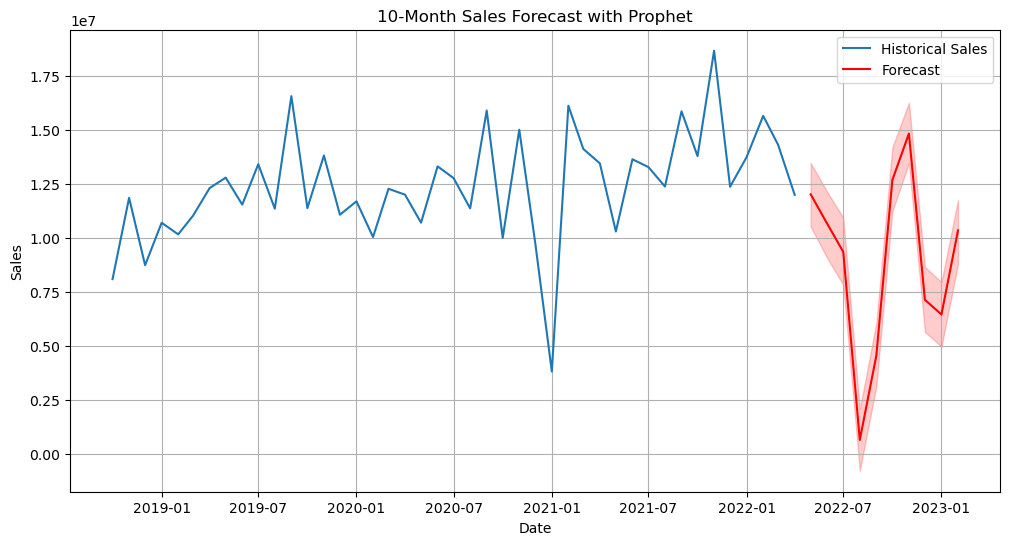

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_12027/2768713773.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_3["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#3,1.202329e+07
2022-06-01,#3,1.065802e+07
2022-07-01,#3,9.357150e+06
2022-08-01,#3,6.293992e+05
2022-09-01,#3,4.543732e+06
2022-10-01,#3,1.268772e+07
2022-11-01,#3,1.484395e+07
2022-12-01,#3,7.131209e+06
2023-01-01,#3,6.450718e+06


In [28]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_3, prophet_best_params_3, prophet_best_rmse_3, "Prophet",
    xgboost_best_model_3, xgboost_best_params_3, xgboost_best_rmse_3, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg3,
        df_market_3,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg3,
        df_market_3,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_3.set_index('Month Year', inplace = True)
test_set_3["Sales_EUR"] = results["yhat"]
test_set_3

# Product 4

In [29]:
test_set_4 = test_set[test_set['Mapped_GCK'] == '#4']
df_market_4 = df_market[selected_features_4]
df_market_4.head()

,PRO27756_org_lag_5,WKLWEUR840_org_lag_3,PRI27276_org_lag_2,PRO28392_org_lag_4,MAB_ELE_PRO156_lag_4,PRO28756_org_lag_6,PRO28392_org_lag_1,MAB_ELE_SHP392_lag_6
date,,,,,,,,
2004-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,NaN,NaN,NaN,NaN,NaN,NaN,110.890034,NaN
2004-04-01,NaN,NaN,93.230453,NaN,NaN,NaN,141.176853,NaN
2004-05-01,NaN,1.2646,93.335678,NaN,NaN,NaN,105.648765,NaN
2004-06-01,NaN,1.2262,93.440903,110.890034,16.940704,NaN,101.990361,NaN


## Xgboost

In [30]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg4, df_market_4, train_size = 0.8)

X_val.info() 

xgboost_best_model_4, xgboost_best_params_4, xgboost_best_rmse_4 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_4)
print("Validation RMSE:", xgboost_best_rmse_4)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PRO27756_org_lag_5    9 non-null      float64
 1   WKLWEUR840_org_lag_3  9 non-null      float64
 2   PRI27276_org_lag_2    9 non-null      float64
 3   PRO28392_org_lag_4    9 non-null      float64
 4   MAB_ELE_PRO156_lag_4  9 non-null      float64
 5   PRO28756_org_lag_6    9 non-null      float64
 6   PRO28392_org_lag_1    9 non-null      float64
 7   MAB_ELE_SHP392_lag_6  9 non-null      float64
dtypes: float64(8)
memory usage: 648.0+ bytes
Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 134467.3879, Relative RMSE: 0.4565
Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_a

## Prophet

In [31]:
prophet_best_model_4, prophet_best_params_4, prophet_best_rmse_4 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_4)

print("Validation RMSE:", prophet_best_rmse_4)

21:03:39 - cmdstanpy - INFO - Chain [1] start processing
21:03:39 - cmdstanpy - INFO - Chain [1] done processing
21:03:39 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 123998.4115, Relative RMSE: 0.4210


21:03:39 - cmdstanpy - INFO - Chain [1] done processing
21:03:39 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 124350.9749, Relative RMSE: 0.4222


21:03:40 - cmdstanpy - INFO - Chain [1] done processing
21:03:40 - cmdstanpy - INFO - Chain [1] start processing
21:03:40 - cmdstanpy - INFO - Chain [1] done processing
21:03:40 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 226288.3183, Relative RMSE: 0.7683
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 72717.7974, Relative RMSE: 0.2469


21:03:40 - cmdstanpy - INFO - Chain [1] done processing
21:03:40 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 169834.6855, Relative RMSE: 0.5766


21:03:41 - cmdstanpy - INFO - Chain [1] done processing
21:03:41 - cmdstanpy - INFO - Chain [1] start processing
21:03:41 - cmdstanpy - INFO - Chain [1] done processing
21:03:41 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 234983.5329, Relative RMSE: 0.7978
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 118998.5427, Relative RMSE: 0.4040


21:03:41 - cmdstanpy - INFO - Chain [1] done processing
21:03:41 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 246147.3384, Relative RMSE: 0.8357


21:03:41 - cmdstanpy - INFO - Chain [1] done processing
21:03:41 - cmdstanpy - INFO - Chain [1] start processing
21:03:41 - cmdstanpy - INFO - Chain [1] done processing
21:03:41 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 310448.8892, Relative RMSE: 1.0540
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 144498.6702, Relative RMSE: 0.4906


21:03:42 - cmdstanpy - INFO - Chain [1] done processing
21:03:42 - cmdstanpy - INFO - Chain [1] start processing
21:03:42 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 144802.1629, Relative RMSE: 0.4916
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 252920.4781, Relative RMSE: 0.8587


21:03:42 - cmdstanpy - INFO - Chain [1] start processing
21:03:42 - cmdstanpy - INFO - Chain [1] done processing
21:03:42 - cmdstanpy - INFO - Chain [1] start processing
21:03:42 - cmdstanpy - INFO - Chain [1] done processing
21:03:42 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 144498.6702, Relative RMSE: 0.4906
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 144802.1629, Relative RMSE: 0.4916


21:03:42 - cmdstanpy - INFO - Chain [1] done processing
21:03:42 - cmdstanpy - INFO - Chain [1] start processing
21:03:42 - cmdstanpy - INFO - Chain [1] done processing
21:03:42 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 252920.4781, Relative RMSE: 0.8587
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 144498.6702, Relative RMSE: 0.4906


21:03:42 - cmdstanpy - INFO - Chain [1] done processing
21:03:43 - cmdstanpy - INFO - Chain [1] start processing
21:03:43 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 144802.1629, Relative RMSE: 0.4916


21:03:43 - cmdstanpy - INFO - Chain [1] start processing
21:03:43 - cmdstanpy - INFO - Chain [1] done processing
21:03:43 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 252920.4781, Relative RMSE: 0.8587
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 145569.4873, Relative RMSE: 0.4942


21:03:43 - cmdstanpy - INFO - Chain [1] done processing
21:03:43 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 145912.2744, Relative RMSE: 0.4954


21:03:43 - cmdstanpy - INFO - Chain [1] done processing
21:03:43 - cmdstanpy - INFO - Chain [1] start processing
21:03:44 - cmdstanpy - INFO - Chain [1] done processing
21:03:44 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 238294.8757, Relative RMSE: 0.8090
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 103165.9350, Relative RMSE: 0.3503


21:03:44 - cmdstanpy - INFO - Chain [1] done processing
21:03:44 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 115542.6386, Relative RMSE: 0.3923


21:03:44 - cmdstanpy - INFO - Chain [1] done processing
21:03:44 - cmdstanpy - INFO - Chain [1] start processing
21:03:44 - cmdstanpy - INFO - Chain [1] done processing
21:03:44 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 177871.9556, Relative RMSE: 0.6039
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 122008.5467, Relative RMSE: 0.4142


21:03:45 - cmdstanpy - INFO - Chain [1] done processing
21:03:45 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 610797.8764, Relative RMSE: 2.0737


21:03:45 - cmdstanpy - INFO - Chain [1] done processing
21:03:45 - cmdstanpy - INFO - Chain [1] start processing
21:03:45 - cmdstanpy - INFO - Chain [1] done processing
21:03:45 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 609761.1794, Relative RMSE: 2.0702
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 144498.6702, Relative RMSE: 0.4906


21:03:45 - cmdstanpy - INFO - Chain [1] done processing
21:03:45 - cmdstanpy - INFO - Chain [1] start processing
21:03:45 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 144802.1629, Relative RMSE: 0.4916


21:03:46 - cmdstanpy - INFO - Chain [1] start processing
21:03:46 - cmdstanpy - INFO - Chain [1] done processing
21:03:46 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 252920.4781, Relative RMSE: 0.8587
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 144498.6702, Relative RMSE: 0.4906


21:03:46 - cmdstanpy - INFO - Chain [1] done processing
21:03:46 - cmdstanpy - INFO - Chain [1] start processing
21:03:46 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 144802.1629, Relative RMSE: 0.4916
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 252920.4781, Relative RMSE: 0.8587


21:03:46 - cmdstanpy - INFO - Chain [1] start processing
21:03:46 - cmdstanpy - INFO - Chain [1] done processing
21:03:46 - cmdstanpy - INFO - Chain [1] start processing
21:03:46 - cmdstanpy - INFO - Chain [1] done processing
21:03:46 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 144498.6702, Relative RMSE: 0.4906
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 144802.1629, Relative RMSE: 0.4916


21:03:46 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 252920.4781, Relative RMSE: 0.8587
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01}
Validation RMSE: 72717.7973535471


21:03:46 - cmdstanpy - INFO - Chain [1] start processing
21:03:47 - cmdstanpy - INFO - Chain [1] done processing


Best Model: Prophet
Best Parameters: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01}
Best RMSE: 72717.7973535471


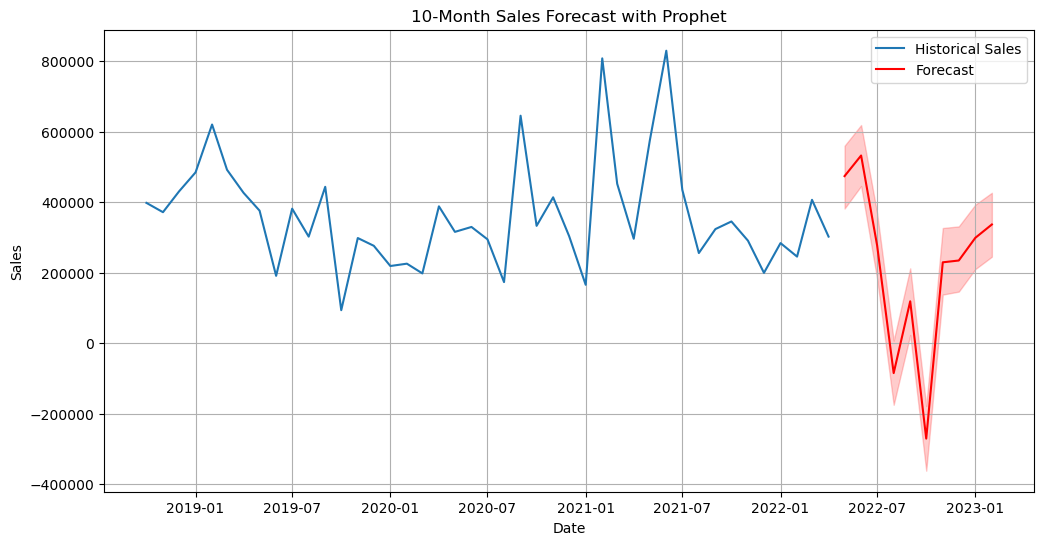

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_12027/679592135.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_4["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#4,473696.143354
2022-06-01,#4,532140.892724
2022-07-01,#4,276921.914433
2022-08-01,#4,-85262.759487
2022-09-01,#4,118594.262392
2022-10-01,#4,-271030.663978
2022-11-01,#4,229125.026149
2022-12-01,#4,234223.625552
2023-01-01,#4,298615.592755


In [32]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_4, prophet_best_params_4, prophet_best_rmse_4, "Prophet",
    xgboost_best_model_4, xgboost_best_params_4, xgboost_best_rmse_4, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg4,
        df_market_4,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg4,
        df_market_4,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_4.set_index('Month Year', inplace = True)
test_set_4["Sales_EUR"] = results["yhat"]
test_set_4

# Product 5

In [33]:
# selecte only the features that are selected in the feature selection step
test_set_5 = test_set[test_set['Mapped_GCK'] == '#5']
df_market_5 = df_market[selected_features_5]
df_market_5.head()

,MAB_ELE_SHP250_lag_1,PRO28392_org_lag_3,MAB_ELE_SHP392,MAB_ELE_PRO826_lag_5,PRO271000_org_lag_5,PRO27392_org,PRI27840_org
date,,,,,,,
2004-02-01,NaN,NaN,110.495272,NaN,NaN,106.161262,78.969864
2004-03-01,83.458866,NaN,144.686166,NaN,NaN,140.288741,79.673569
2004-04-01,106.168192,NaN,102.655769,NaN,NaN,106.271197,80.337639
2004-05-01,92.007646,110.890034,100.305285,NaN,NaN,101.608710,80.798828
2004-06-01,85.696486,141.176853,119.616380,NaN,NaN,116.655248,80.913490


## Xgboost

In [34]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg5, df_market_5, train_size = 0.8)

X_val.info() 

xgboost_best_model_5, xgboost_best_params_5, xgboost_best_rmse_5 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_5)
print("Validation RMSE:", xgboost_best_rmse_5)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MAB_ELE_SHP250_lag_1  9 non-null      float64
 1   PRO28392_org_lag_3    9 non-null      float64
 2   MAB_ELE_SHP392        9 non-null      float64
 3   MAB_ELE_PRO826_lag_5  9 non-null      float64
 4   PRO271000_org_lag_5   9 non-null      float64
 5   PRO27392_org          9 non-null      float64
 6   PRI27840_org          9 non-null      float64
dtypes: float64(7)
memory usage: 576.0+ bytes
Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 3865861.1241, Relative RMSE: 0.3348
Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0.1} => RMSE: 3839530.6859

## Prophet

In [35]:
prophet_best_model_5, prophet_best_params_5, prophet_best_rmse_5 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_5)

print("Validation RMSE:", prophet_best_rmse_5)

21:10:53 - cmdstanpy - INFO - Chain [1] start processing
21:10:53 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 4982128.4867, Relative RMSE: 0.4315


21:10:53 - cmdstanpy - INFO - Chain [1] start processing
21:10:53 - cmdstanpy - INFO - Chain [1] done processing
21:10:54 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 4983480.5166, Relative RMSE: 0.4316


21:10:54 - cmdstanpy - INFO - Chain [1] done processing
21:10:54 - cmdstanpy - INFO - Chain [1] start processing
21:10:54 - cmdstanpy - INFO - Chain [1] done processing
21:10:54 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 5595887.1279, Relative RMSE: 0.4846
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 31063910.7621, Relative RMSE: 2.6903


21:10:54 - cmdstanpy - INFO - Chain [1] done processing
21:10:54 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 32243244.3887, Relative RMSE: 2.7924


21:10:54 - cmdstanpy - INFO - Chain [1] done processing
21:10:54 - cmdstanpy - INFO - Chain [1] start processing
21:10:55 - cmdstanpy - INFO - Chain [1] done processing
21:10:55 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 32775159.0302, Relative RMSE: 2.8385
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 40418267.9390, Relative RMSE: 3.5004


21:10:55 - cmdstanpy - INFO - Chain [1] done processing
21:10:55 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 39625136.2968, Relative RMSE: 3.4317


21:10:55 - cmdstanpy - INFO - Chain [1] done processing
21:10:55 - cmdstanpy - INFO - Chain [1] start processing
21:10:55 - cmdstanpy - INFO - Chain [1] done processing
21:10:55 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 38736236.7178, Relative RMSE: 3.3548
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 4159482.6944, Relative RMSE: 0.3602


21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:10:56 - cmdstanpy - INFO - Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:10:56 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 4161589.6047, Relative RMSE: 0.3604
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 4468719.3129, Relative RMSE: 0.3870


21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:10:56 - cmdstanpy - INFO - Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:10:56 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 4159482.6944, Relative RMSE: 0.3602
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 4161589.6047, Relative RMSE: 0.3604


21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:10:56 - cmdstanpy - INFO - Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:10:56 - cmdstanpy - INFO - Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 4468719.3129, Relative RMSE: 0.3870
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 4159482.6944, Relative RMSE: 0.3602


21:10:56 - cmdstanpy - INFO - Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:10:57 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 4161589.6047, Relative RMSE: 0.3604
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 4468719.3129, Relative RMSE: 0.3870


21:10:57 - cmdstanpy - INFO - Chain [1] done processing
21:10:57 - cmdstanpy - INFO - Chain [1] start processing
21:10:57 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 4733039.7117, Relative RMSE: 0.4099


21:10:57 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 4716873.9866, Relative RMSE: 0.4085


21:10:57 - cmdstanpy - INFO - Chain [1] done processing
21:10:57 - cmdstanpy - INFO - Chain [1] start processing
21:10:57 - cmdstanpy - INFO - Chain [1] done processing
21:10:57 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 5123243.9890, Relative RMSE: 0.4437
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 18972282.1576, Relative RMSE: 1.6431


21:10:57 - cmdstanpy - INFO - Chain [1] done processing
21:10:58 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 18986993.7572, Relative RMSE: 1.6444


21:10:58 - cmdstanpy - INFO - Chain [1] done processing
21:10:58 - cmdstanpy - INFO - Chain [1] start processing
21:10:58 - cmdstanpy - INFO - Chain [1] done processing
21:10:58 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 20695384.4641, Relative RMSE: 1.7923
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 40775458.4366, Relative RMSE: 3.5314


21:10:58 - cmdstanpy - INFO - Chain [1] done processing
21:10:58 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 35802654.5901, Relative RMSE: 3.1007


21:10:58 - cmdstanpy - INFO - Chain [1] done processing
21:10:59 - cmdstanpy - INFO - Chain [1] start processing
21:10:59 - cmdstanpy - INFO - Chain [1] done processing
21:10:59 - cmdstanpy - INFO - Chain [1] start processing
21:10:59 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 33305602.5906, Relative RMSE: 2.8844
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 4159482.6944, Relative RMSE: 0.3602


21:10:59 - cmdstanpy - INFO - Chain [1] start processing
21:10:59 - cmdstanpy - INFO - Chain [1] done processing
21:10:59 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 4161589.6047, Relative RMSE: 0.3604
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 4468719.3129, Relative RMSE: 0.3870


21:10:59 - cmdstanpy - INFO - Chain [1] done processing
21:10:59 - cmdstanpy - INFO - Chain [1] start processing
21:10:59 - cmdstanpy - INFO - Chain [1] done processing
21:10:59 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 4159482.6944, Relative RMSE: 0.3602
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 4161589.6047, Relative RMSE: 0.3604


21:10:59 - cmdstanpy - INFO - Chain [1] done processing
21:10:59 - cmdstanpy - INFO - Chain [1] start processing
21:10:59 - cmdstanpy - INFO - Chain [1] done processing
21:10:59 - cmdstanpy - INFO - Chain [1] start processing
21:10:59 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 4468719.3129, Relative RMSE: 0.3870
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 4159482.6944, Relative RMSE: 0.3602


21:11:00 - cmdstanpy - INFO - Chain [1] start processing
21:11:00 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 4161589.6047, Relative RMSE: 0.3604
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 4468719.3129, Relative RMSE: 0.3870
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01}
Validation RMSE: 4159482.6944094505


## Final prediction

Best Model: XGBoost
Best Parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.3, 'subsample': 0.7, 'colsample_bytree': 1, 'gamma': 0.1, 'reg_alpha': 0, 'reg_lambda': 0.1}
Best RMSE: 2848781.503851229


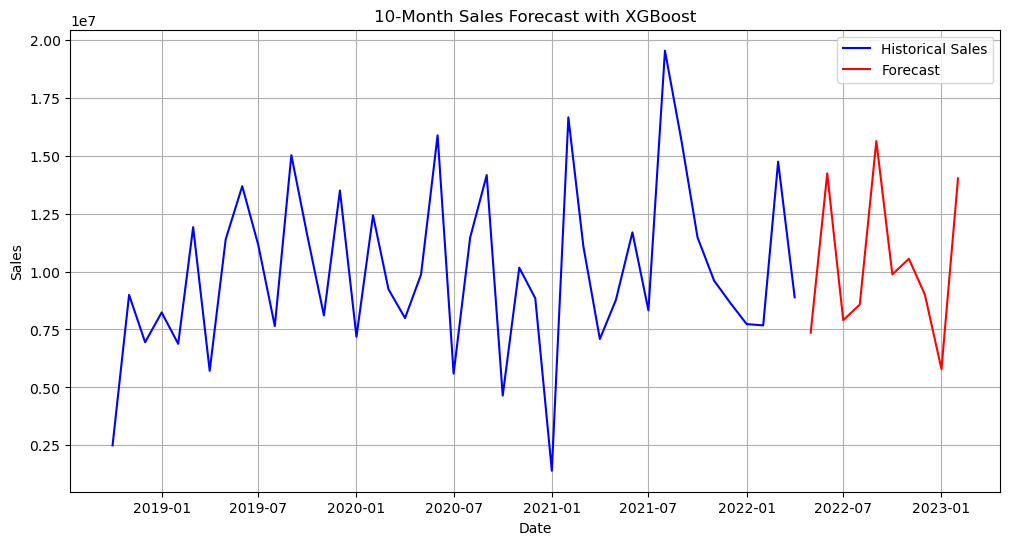

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_12027/3577769835.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_5["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#5,7360519.0
2022-06-01,#5,14231931.0
2022-07-01,#5,7899854.5
2022-08-01,#5,8574638.0
2022-09-01,#5,15627631.0
2022-10-01,#5,9876038.0
2022-11-01,#5,10548580.0
2022-12-01,#5,8999120.0
2023-01-01,#5,5789911.0


In [36]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_5, prophet_best_params_5, prophet_best_rmse_5, "Prophet",
    xgboost_best_model_5, xgboost_best_params_5, xgboost_best_rmse_5, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg5,
        df_market_5,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg5,
        df_market_5,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_5.set_index('Month Year', inplace = True)
test_set_5["Sales_EUR"] = results["yhat"]
test_set_5

# Product 6

In [37]:
# selecte only the features that are selected in the feature selection step
test_set_6 = test_set[test_set['Mapped_GCK'] == '#6']
df_market_6 = df_market[selected_features_6]
df_market_6.head()

,PRO27276_org,MAB_ELE_PRO392_lag_5,PRO27276_org_lag_1,MAB_ELE_SHP250_lag_1,WKLWEUR840_org_lag_2,PRO28756_org,PRI27250_org_lag_3,MAB_ELE_SHP156_lag_4
date,,,,,,,,
2004-02-01,85.913200,NaN,NaN,NaN,NaN,96.177481,NaN,NaN
2004-03-01,97.670815,NaN,85.913200,83.458866,NaN,96.250927,NaN,NaN
2004-04-01,87.253983,NaN,97.670815,106.168192,1.2646,96.330211,NaN,NaN
2004-05-01,84.675552,NaN,87.253983,92.007646,1.2262,96.413549,96.864647,NaN
2004-06-01,95.401802,NaN,84.675552,85.696486,1.1985,96.499291,96.864653,16.940704


## Xgboost

In [38]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg6, df_market_6, train_size = 0.8)

X_val.info() 

xgboost_best_model_6, xgboost_best_params_6, xgboost_best_rmse_6 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_6)
print("Validation RMSE:", xgboost_best_rmse_6)


<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PRO27276_org          9 non-null      float64
 1   MAB_ELE_PRO392_lag_5  9 non-null      float64
 2   PRO27276_org_lag_1    9 non-null      float64
 3   MAB_ELE_SHP250_lag_1  9 non-null      float64
 4   WKLWEUR840_org_lag_2  9 non-null      float64
 5   PRO28756_org          9 non-null      float64
 6   PRI27250_org_lag_3    9 non-null      float64
 7   MAB_ELE_SHP156_lag_4  9 non-null      float64
dtypes: float64(8)
memory usage: 648.0+ bytes
Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 249239.5402, Relative RMSE: 0.6503
Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_a

## Prophet

In [39]:
prophet_best_model_6, prophet_best_params_6, prophet_best_rmse_6 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_6)

print("Validation RMSE:", prophet_best_rmse_6)

21:17:33 - cmdstanpy - INFO - Chain [1] start processing
21:17:33 - cmdstanpy - INFO - Chain [1] done processing
21:17:33 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 257999.9592, Relative RMSE: 0.6732


21:17:34 - cmdstanpy - INFO - Chain [1] done processing
21:17:34 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 260638.8541, Relative RMSE: 0.6801


21:17:34 - cmdstanpy - INFO - Chain [1] done processing
21:17:34 - cmdstanpy - INFO - Chain [1] start processing
21:17:34 - cmdstanpy - INFO - Chain [1] done processing
21:17:34 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 260681.3379, Relative RMSE: 0.6802
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 1559287.7754, Relative RMSE: 4.0686


21:17:34 - cmdstanpy - INFO - Chain [1] done processing
21:17:34 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 1553613.7699, Relative RMSE: 4.0538


21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 1682213.4547, Relative RMSE: 4.3894
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 2641950.3574, Relative RMSE: 6.8936


21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 2645366.0851, Relative RMSE: 6.9025


21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 2578237.7432, Relative RMSE: 6.7273
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 247572.7282, Relative RMSE: 0.6460


21:17:36 - cmdstanpy - INFO - Chain [1] done processing
21:17:36 - cmdstanpy - INFO - Chain [1] start processing
21:17:36 - cmdstanpy - INFO - Chain [1] done processing
21:17:36 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 247544.5017, Relative RMSE: 0.6459
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 247605.4206, Relative RMSE: 0.6461


21:17:36 - cmdstanpy - INFO - Chain [1] done processing
21:17:36 - cmdstanpy - INFO - Chain [1] start processing
21:17:36 - cmdstanpy - INFO - Chain [1] done processing
21:17:36 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 247572.7282, Relative RMSE: 0.6460
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 247544.5017, Relative RMSE: 0.6459


21:17:36 - cmdstanpy - INFO - Chain [1] done processing
21:17:36 - cmdstanpy - INFO - Chain [1] start processing
21:17:36 - cmdstanpy - INFO - Chain [1] done processing
21:17:36 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 247605.4206, Relative RMSE: 0.6461
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 247572.7282, Relative RMSE: 0.6460


21:17:36 - cmdstanpy - INFO - Chain [1] done processing
21:17:36 - cmdstanpy - INFO - Chain [1] start processing
21:17:37 - cmdstanpy - INFO - Chain [1] done processing
21:17:37 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 247544.5017, Relative RMSE: 0.6459
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 247605.4206, Relative RMSE: 0.6461


21:17:37 - cmdstanpy - INFO - Chain [1] done processing
21:17:37 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 269803.2345, Relative RMSE: 0.7040


21:17:37 - cmdstanpy - INFO - Chain [1] done processing
21:17:37 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 270589.4866, Relative RMSE: 0.7060


21:17:38 - cmdstanpy - INFO - Chain [1] done processing
21:17:38 - cmdstanpy - INFO - Chain [1] start processing
21:17:38 - cmdstanpy - INFO - Chain [1] done processing
21:17:38 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 270316.2782, Relative RMSE: 0.7053
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 446589.8292, Relative RMSE: 1.1653


21:17:38 - cmdstanpy - INFO - Chain [1] done processing
21:17:38 - cmdstanpy - INFO - Chain [1] start processing
21:17:38 - cmdstanpy - INFO - Chain [1] done processing
21:17:38 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 446202.7328, Relative RMSE: 1.1643
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 451834.3327, Relative RMSE: 1.1790


21:17:38 - cmdstanpy - INFO - Chain [1] done processing
21:17:38 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 2361610.0568, Relative RMSE: 6.1621


21:17:38 - cmdstanpy - INFO - Chain [1] done processing
21:17:38 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 2359404.8812, Relative RMSE: 6.1563


21:17:39 - cmdstanpy - INFO - Chain [1] done processing
21:17:39 - cmdstanpy - INFO - Chain [1] start processing
21:17:39 - cmdstanpy - INFO - Chain [1] done processing
21:17:39 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 2107338.7149, Relative RMSE: 5.4986
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 247572.7282, Relative RMSE: 0.6460


21:17:39 - cmdstanpy - INFO - Chain [1] done processing
21:17:39 - cmdstanpy - INFO - Chain [1] start processing
21:17:39 - cmdstanpy - INFO - Chain [1] done processing
21:17:39 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 247544.5017, Relative RMSE: 0.6459
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 247605.4206, Relative RMSE: 0.6461


21:17:39 - cmdstanpy - INFO - Chain [1] done processing
21:17:39 - cmdstanpy - INFO - Chain [1] start processing
21:17:39 - cmdstanpy - INFO - Chain [1] done processing
21:17:39 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 247572.7282, Relative RMSE: 0.6460
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 247544.5017, Relative RMSE: 0.6459


21:17:40 - cmdstanpy - INFO - Chain [1] done processing
21:17:40 - cmdstanpy - INFO - Chain [1] start processing
21:17:40 - cmdstanpy - INFO - Chain [1] done processing
21:17:40 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 247605.4206, Relative RMSE: 0.6461
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 247572.7282, Relative RMSE: 0.6460


21:17:40 - cmdstanpy - INFO - Chain [1] done processing
21:17:40 - cmdstanpy - INFO - Chain [1] start processing
21:17:40 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 247544.5017, Relative RMSE: 0.6459
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 247605.4206, Relative RMSE: 0.6461
Best Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1}
Validation RMSE: 247544.50169477612


## Final prediction

Best Model: XGBoost
Best Parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Best RMSE: 185375.10060058878


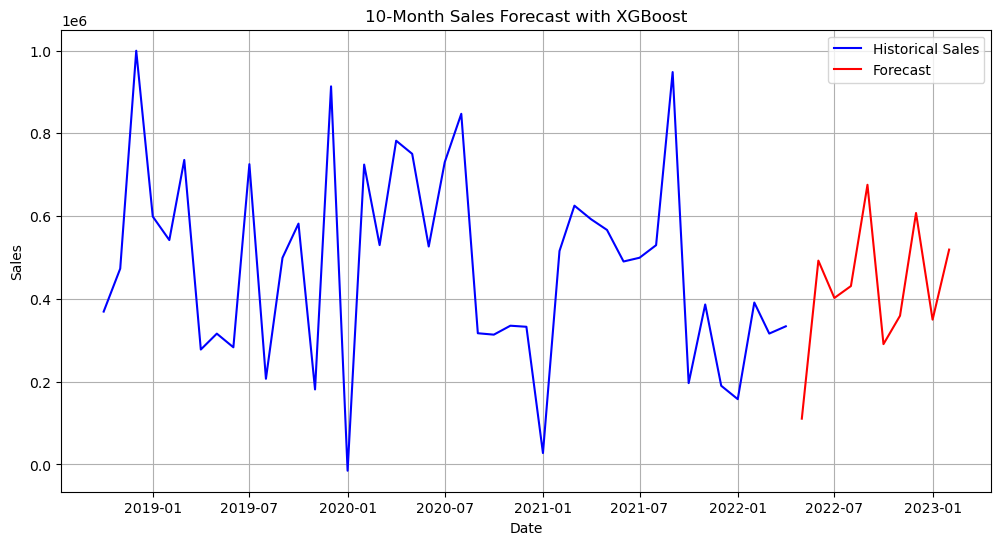

/var/folders/z6/_vn8cndd4x5dmx2cpjfdkjdr0000gn/T/ipykernel_12027/2742990063.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_6["Sales_EUR"] = results["yhat"]


,Mapped_GCK,Sales_EUR
Month Year,,
2022-05-01,#6,110562.367188
2022-06-01,#6,492381.343750
2022-07-01,#6,402148.875000
2022-08-01,#6,430923.062500
2022-09-01,#6,675594.125000
2022-10-01,#6,290625.156250
2022-11-01,#6,359236.000000
2022-12-01,#6,607434.687500
2023-01-01,#6,349747.531250


In [40]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_6, prophet_best_params_6, prophet_best_rmse_6, "Prophet",
    xgboost_best_model_6, xgboost_best_params_6, xgboost_best_rmse_6, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg6,
        df_market_6,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg6,
        df_market_6,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_6.set_index('Month Year', inplace = True)
test_set_6["Sales_EUR"] = results["yhat"]
test_set_6

# Product 8

In [41]:
# selecte only the features that are selected in the feature selection step
test_set_8 = test_set[test_set['Mapped_GCK'] == '#8']
df_market_8 = df_market[selected_features_8]
df_market_8.head()

,MAB_ELE_SHP840_lag_6,PRO28392_org_lag_4,MAB_ELE_SHP250_lag_3,MAB_ELE_SHP250_lag_4,WKLWEUR840_org_lag_1,MAB_ELE_SHP392_lag_1,PRO27826_org_lag_3,PRO27392_org_lag_4
date,,,,,,,,
2004-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,NaN,NaN,NaN,NaN,1.2646,110.495272,NaN,NaN
2004-04-01,NaN,NaN,NaN,NaN,1.2262,144.686166,NaN,NaN
2004-05-01,NaN,NaN,83.458866,NaN,1.1985,102.655769,120.706516,NaN
2004-06-01,NaN,110.890034,106.168192,83.458866,1.2007,100.305285,138.309550,106.161262


## Xgboost

In [42]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg8, df_market_8, train_size = 0.8)

X_val.info() 

xgboost_best_model_8, xgboost_best_params_8, xgboost_best_rmse_8 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_8)
print("Validation RMSE:", xgboost_best_rmse_8)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MAB_ELE_SHP840_lag_6  9 non-null      float64
 1   PRO28392_org_lag_4    9 non-null      float64
 2   MAB_ELE_SHP250_lag_3  9 non-null      float64
 3   MAB_ELE_SHP250_lag_4  9 non-null      float64
 4   WKLWEUR840_org_lag_1  9 non-null      float64
 5   MAB_ELE_SHP392_lag_1  9 non-null      float64
 6   PRO27826_org_lag_3    9 non-null      float64
 7   PRO27392_org_lag_4    9 non-null      float64
dtypes: float64(8)
memory usage: 648.0+ bytes
Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 696045.0098, Relative RMSE: 0.5467
Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_a

KeyboardInterrupt: 

## Prophet

In [ ]:
prophet_best_model_8, prophet_best_params_8, prophet_best_rmse_8 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_8)

print("Validation RMSE:", prophet_best_rmse_8)

## Final prediction

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_8, prophet_best_params_8, prophet_best_rmse_8, "Prophet",
    xgboost_best_model_8, xgboost_best_params_8, xgboost_best_rmse_8, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg8,
        df_market_8,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg8,
        df_market_8,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_8.set_index('Month Year', inplace = True)
test_set_8["Sales_EUR"] = results["yhat"]
test_set_8

# Product 9

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_9 = test_set[test_set['Mapped_GCK'] == '#9']
df_market_9 = df_market[selected_features_9]
df_market_9.head()

## Xgboost 

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg9, df_market_9, train_size = 0.8)

X_val.info() 

xgboost_best_model_9, xgboost_best_params_9, xgboost_best_rmse_9 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_9)
print("Validation RMSE:", xgboost_best_rmse_9)

## Prophet

In [ ]:
prophet_best_model_9, prophet_best_params_9, prophet_best_rmse_9 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_9)

print("Validation RMSE:", prophet_best_rmse_9)

## Final prediction 

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_9, prophet_best_params_9, prophet_best_rmse_9, "Prophet",
    xgboost_best_model_9, xgboost_best_params_9, xgboost_best_rmse_9, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg9,
        df_market_9,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg9,
        df_market_9,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_9.set_index('Month Year', inplace = True)
test_set_9["Sales_EUR"] = results["yhat"]
test_set_9

# Product 11

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_11 = test_set[test_set['Mapped_GCK'] == '#11']
df_market_11 = df_market[selected_features_11]
df_market_11.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg11, df_market_11, train_size = 0.8)

X_val.info() 

xgboost_best_model_11, xgboost_best_params_11, xgboost_best_rmse_11 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_11)
print("Validation RMSE:", xgboost_best_rmse_11)

## Prophet

In [ ]:
prophet_best_model_11, prophet_best_params_11, prophet_best_rmse_11 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_11)

print("Validation RMSE:", prophet_best_rmse_11)

## Final prediction 

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_11, prophet_best_params_11, prophet_best_rmse_11, "Prophet",
    xgboost_best_model_11, xgboost_best_params_11, xgboost_best_rmse_11, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg11,
        df_market_11,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg11,
        df_market_11,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_11.set_index('Month Year', inplace = True)
test_set_11["Sales_EUR"] = results["yhat"]
test_set_11

# Product 12

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_12 = test_set[test_set['Mapped_GCK'] == '#12']
df_market_12 = df_market[selected_features_12]
df_market_12.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg12, df_market_12, train_size = 0.8)

X_val.info() 

xgboost_best_model_12, xgboost_best_params_12, xgboost_best_rmse_12 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_12)
print("Validation RMSE:", xgboost_best_rmse_12)

## Prophet

In [ ]:
prophet_best_model_12, prophet_best_params_12, prophet_best_rmse_12 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_12)

print("Validation RMSE:", prophet_best_rmse_12)

## Final prediction

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_12, prophet_best_params_12, prophet_best_rmse_12, "Prophet",
    xgboost_best_model_12, xgboost_best_params_12, xgboost_best_rmse_12, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg12,
        df_market_12,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg12,
        df_market_12,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_12.set_index('Month Year', inplace = True)
test_set_12["Sales_EUR"] = results["yhat"]
test_set_12

# Product 13

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_13 = test_set[test_set['Mapped_GCK'] == '#13']
df_market_13 = df_market[selected_features_13]
df_market_13.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg13, df_market_13, train_size = 0.8)

X_val.info() 

xgboost_best_model_13, xgboost_best_params_13, xgboost_best_rmse_13 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_13)
print("Validation RMSE:", xgboost_best_rmse_13)

## Prophet

In [ ]:
prophet_best_model_13, prophet_best_params_13, prophet_best_rmse_13 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_13)

print("Validation RMSE:", prophet_best_rmse_13)

## Final prediction 

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_13, prophet_best_params_13, prophet_best_rmse_13, "Prophet",
    xgboost_best_model_13, xgboost_best_params_13, xgboost_best_rmse_13, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg13,
        df_market_13,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg13,
        df_market_13,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_13.set_index('Month Year', inplace = True)
test_set_13["Sales_EUR"] = results["yhat"]
test_set_13

# Product 14

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_14 = test_set[test_set['Mapped_GCK'] == '#14']
df_market_14 = df_market[selected_features_14]
df_market_14.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg14, df_market_14, train_size = 0.8)

X_val.info() 

xgboost_best_model_14, xgboost_best_params_14, xgboost_best_rmse_14 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_14)
print("Validation RMSE:", xgboost_best_rmse_14)

## Prophet

In [ ]:
prophet_best_model_14, prophet_best_params_14, prophet_best_rmse_14 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_14)

print("Validation RMSE:", prophet_best_rmse_14)

## Final prediction 

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_14, prophet_best_params_14, prophet_best_rmse_14, "Prophet",
    xgboost_best_model_14, xgboost_best_params_14, xgboost_best_rmse_14, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg14,
        df_market_14,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg14,
        df_market_14,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_14.set_index('Month Year', inplace = True)
test_set_14["Sales_EUR"] = results["yhat"]
test_set_14

# Product 16

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_16 = test_set[test_set['Mapped_GCK'] == '#16']
df_market_16 = df_market[selected_features_16]
df_market_16.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg16, df_market_16, train_size = 0.8)

X_val.info() 

xgboost_best_model_16, xgboost_best_params_16, xgboost_best_rmse_16 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_16)
print("Validation RMSE:", xgboost_best_rmse_16)

## Prophet

In [ ]:
prophet_best_model_16, prophet_best_params_16, prophet_best_rmse_16 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_16)

print("Validation RMSE:", prophet_best_rmse_16)

## Final prediction 

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_16, prophet_best_params_16, prophet_best_rmse_16, "Prophet",
    xgboost_best_model_16, xgboost_best_params_16, xgboost_best_rmse_16, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg16,
        df_market_16,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg16,
        df_market_16,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_16.set_index('Month Year', inplace = True)
test_set_16["Sales_EUR"] = results["yhat"]
test_set_16

# Product 20

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_20 = test_set[test_set['Mapped_GCK'] == '#20']
df_market_20 = df_market[selected_features_20]
df_market_20.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg20, df_market_20, train_size = 0.8)

X_val.info() 

xgboost_best_model_20, xgboost_best_params_20, xgboost_best_rmse_20 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_20)
print("Validation RMSE:", xgboost_best_rmse_20)


## Prophet

In [ ]:
prophet_best_model_20, prophet_best_params_20, prophet_best_rmse_20 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_20)

print("Validation RMSE:", prophet_best_rmse_20)

## Final prediction

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_20, prophet_best_params_20, prophet_best_rmse_20, "Prophet",
    xgboost_best_model_20, xgboost_best_params_20, xgboost_best_rmse_20, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg20,
        df_market_20,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg20,
        df_market_20,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_20.set_index('Month Year', inplace = True)
test_set_20["Sales_EUR"] = results["yhat"]
test_set_20

# Product 36

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_36 = test_set[test_set['Mapped_GCK'] == '#36']
df_market_36 = df_market[selected_features_36]
df_market_36.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg36, df_market_36, train_size = 0.8)

X_val.info() 

xgboost_best_model_36, xgboost_best_params_36, xgboost_best_rmse_36 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_36)
print("Validation RMSE:", xgboost_best_rmse_36)


## Prophet

In [ ]:
prophet_best_model_36, prophet_best_params_36, prophet_best_rmse_36 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_36)

print("Validation RMSE:", prophet_best_rmse_36)

## Final prediction

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_36, prophet_best_params_36, prophet_best_rmse_36, "Prophet",
    xgboost_best_model_36, xgboost_best_params_36, xgboost_best_rmse_36, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg36,
        df_market_36,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg36,
        df_market_36,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_36.set_index('Month Year', inplace = True)
test_set_36["Sales_EUR"] = results["yhat"]
test_set_36

# Exporting

In [ ]:


test_set = pd.concat([test_set_1, test_set_3, test_set_4, test_set_5, test_set_6, test_set_8, test_set_9,
                     test_set_11, test_set_12, test_set_13, test_set_14, test_set_16, test_set_20, test_set_36])

def revert_month_year(date_obj):
    reverse_month_map = {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "Mai",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Okt",
        11: "Nov",
        12: "Dez"
    }
    # Format as e.g. "Jan20" (adjust the format if a space is needed)
    return f"{reverse_month_map[date_obj.month]} {date_obj.strftime('%y')}"

# Revert the conversion on the 'Month Year' column
test_set['Month Year'] = test_set['Month Year'].apply(revert_month_year)

test_set.to_csv('../data/test_set_predicted.csv', index=False)